<a href="https://colab.research.google.com/github/Balogunhabeeb14/data-science-ipython-notebooks/blob/master/Topic_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Supervised & Unsupervised Approach to Topic Modelling in Python 

Code and text is motivated by the work of Vatsai

https://towardsdatascience.com/supervised-unsupervised-approach-to-topic-modelling-in-python-d03e0b9da1dc

In [44]:
from pybliometrics.scopus import *

Creating config file at /root/.pybliometrics/config.ini with default paths...
Please enter your API Key(s), obtained from http://dev.elsevier.com/myapikey.html.  Separate multiple keys by comma:
f7f54c19f1168d14c9606d96089364db
API Keys are sufficient for most users.  If you have an InstToken, please enter the token now; otherwise just press Enter:

Configuration file successfully created at /root/.pybliometrics/config.ini
For details see https://pybliometrics.rtfd.io/en/stable/configuration.html.


In [46]:
import arxiv
from pybliometrics.scopus import *
import string
import unidecode
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# https://stackoverflow.com/questions/66096149/pyldavis-visualization-from-gensim-not-displaying-the-result-in-google-colab
# newer versions of pyLDAvis do not seem to work with Notebooks, install version 2.1.2 specifically if you're running into errors!
import pyLDAvis.gensim
import nltk
from typing import List
from wordcloud import WordCloud
from gensim import models, corpora
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

try:
    from nltk.corpus import stopwords
except:
    import nltk
    nltk.download('stopwords')
finally:
    from nltk.corpus import stopwords
    
# constants
sns.set()

queries = ['automl', 'recommender system', 'nlp', 'data science','machinelearning','deeplearning','computer vision','videoanalytics','GAN','robotics']

# load data
def search_arxiv(queries: List[str], max_results: int = 100) -> pd.DataFrame:
    '''
    This function will search arxiv associated to a set of queries and store
    the latest 10000 (max_results) associated to that search.
    
    Args:
        queries: List of strings containing keywords you want to search on Arxiv
        max_results: Integer, representing the maximum number of results you want to 
                     see associated to your search. Default value is 1000, capped at
                     300000.
                            
    Returns:
        This function will return a DataFrame holding the following columns associated
        to the queries the user has passed. 
            `title`, `date`, `article_id`, `url`, `main_topic`, `all_topics`
    
    Example:
        research_df = search_arxiv(
            queries = ['automl', 'recommender system', 'nlp', 'data science'],
            max_results = 10000
        )
    '''
    d = []
    searches = []
    # hitting the API
    for query in queries:
        search = arxiv.Search(
          query = query,
          max_results = max_results,
          sort_by = arxiv.SortCriterion.SubmittedDate,
          sort_order = arxiv.SortOrder.Descending
        )
        searches.append(search)
    
    # Converting search result into df
    for search in searches:
        for res in search.results():
            data = {
                'title' : res.title,
                'date' : res.published,
                'article_id' : res.entry_id,
                'url' : res.pdf_url,
                'main_topic' : res.primary_category,
                'summary' : res.summary,
                'all_topics' : res.categories,
                'authors' : res.authors
            }
            d.append(data)
        
    d = pd.DataFrame(d)
    d['year'] = pd.DatetimeIndex(d['date']).year
    
    # change article id from url to integer
    unique_article_ids = d.article_id.unique()
    article_mapping = {art:idx for idx,art in enumerate(unique_article_ids)}
    d['article_id'] = d['article_id'].map(article_mapping)
    return d

In [49]:
# fetch data from arXiv
research_df = search_arxiv(
    queries = queries,
    max_results = 500
)
print(research_df.shape)

(3421, 9)


In [50]:
research_df.head()

,title,date,article_id,url,main_topic,summary,all_topics,authors,year
0,DivBO: Diversity-aware CASH for Ensemble Learning,2023-02-07 04:53:21+00:00,0,http://arxiv.org/pdf/2302.03255v1,cs.LG,The Combined Algorithm Selection and Hyperpara...,[cs.LG],"[Yu Shen, Yupeng Lu, Yang Li, Yaofeng Tu, Went...",2023
1,Open Problems in Applied Deep Learning,2023-01-26 18:55:43+00:00,1,http://arxiv.org/pdf/2301.11316v1,cs.LG,This work formulates the machine learning mech...,"[cs.LG, cs.AI, cs.CV, cs.HC, cs.IR]",[Maziar Raissi],2023
2,RF+clust for Leave-One-Problem-Out Performance...,2023-01-23 16:14:59+00:00,2,http://arxiv.org/pdf/2301.09524v2,cs.NE,Per-instance automated algorithm configuration...,"[cs.NE, cs.AI]","[Ana Nikolikj, Carola Doerr, Tome Eftimov]",2023
3,Improvement of Computational Performance of Ev...,2023-01-12 15:59:04+00:00,3,http://arxiv.org/pdf/2301.05102v1,cs.LG,Resource-intensive computations are a major fa...,"[cs.LG, cs.NE, cs.PF]","[Nikolay O. Nikitin, Sergey Teryoshkin, Valeri...",2023
4,Data-driven photometric redshift estimation fr...,2022-12-30 13:01:41+00:00,4,http://arxiv.org/pdf/2212.14668v1,astro-ph.IM,Redshift measurement has always been a constan...,"[astro-ph.IM, astro-ph.CO]","[Felipe M F de Oliveira, Marcelo Vargas dos Sa...",2022


Cleaning & Preprocessing
Now we can clean and preprocess the summary information associated with each article. The cleaning and preprocessing phase of working with text data is essential in optimizing the performance of the underlying models. The lower the quality of data you feed into the model, the lower the performance of it will be in production settings. Furthermore, the amount of data you clean, preprocess and reduce will impact the training and inference time associated with the model. This will overall improve the experiments you run and performance in production. Topic modelling algorithms rely on the frequency of words within a document to identify patterns and topics, so any irrelevant information passed in can skew the results.

The text preprocessing we will be doing will consist of the following:

Unicode the input data. This is critical when working with data in different languages. It will convert à into á , this will be critical during the cleaning phase.
Lowering the text such that all upper case characters are now lower case.
The text cleaning we will be doing will consist of the following:

Removing punctuations
Removing stop words
When removing stop words, be mindful of the data you’re working with. The reason you would want to remove stop words is because they don’t provide any new information and it aids in optimizing the performance of the model. The instances where you wouldn’t want to remove stop words is when the context around the sentence matters. Not removing stop words would be useful for things like sentiment analysis and summarization. However, for our use case of topic modelling, we can proceed with removal of stop words.



In [51]:
import nltk
nltk.download('stopwords')
def remove_stopwords(text: str, sw: List[str] = stopwords.words('english')) -> str:
    '''
    This function will remove stopwords from the text
    
    Args:
        text: String of data you want to remove stopwords from
        sw: List of strings indicating the list of stopwords
        
    Returns:
        The input string with the stopwords removed.
    '''
    additional_sw = ['we', 'the', 'this', 'via', 'using']
    sw = sw + additional_sw
    
    text_list = text.split()
    text_list = [word for word in text_list if word.lower() not in sw]
    return ' '.join(text_list)
    
def remove_punctuation(text: str, punct: str = string.punctuation) -> str:
    '''
    This function will remove punctuations from the text.
    
    Args:
        text: String of data you want to remove punctuations from
        punct: String of punctuations
    
    Returns:
        The input string with the punctuations removed.
    '''
    cleaned_text = ''.join([char for char in text if char not in punct])
    return cleaned_text
    
def unicode(text: str) -> str:
    '''
    This function will make all the data unicoded. Meaning Â -> A
    
    Args:
        text: String of data you want to unicode
    
    Returns:
        The input string unicoded.
    '''
    return unidecode.unidecode(text)
    
def clean(text: str) -> str:
    '''
    This method will clean the input text through unidecoding and stopword and punctuation 
    removal.
    
    Args:
        text: String indicating the body of text you want to clean
    
    Returns:
        A string corresponding to the cleaned version of the input string.
    '''
    text = unicode(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    return text.lower()



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:
research_df['cleaned_summary'] = research_df['summary'].apply(lambda x : clean(x))

In [53]:
research_df.head()

,title,date,article_id,url,main_topic,summary,all_topics,authors,year,cleaned_summary
0,DivBO: Diversity-aware CASH for Ensemble Learning,2023-02-07 04:53:21+00:00,0,http://arxiv.org/pdf/2302.03255v1,cs.LG,The Combined Algorithm Selection and Hyperpara...,[cs.LG],"[Yu Shen, Yupeng Lu, Yang Li, Yaofeng Tu, Went...",2023,combined algorithm selection hyperparameters o...
1,Open Problems in Applied Deep Learning,2023-01-26 18:55:43+00:00,1,http://arxiv.org/pdf/2301.11316v1,cs.LG,This work formulates the machine learning mech...,"[cs.LG, cs.AI, cs.CV, cs.HC, cs.IR]",[Maziar Raissi],2023,work formulates machine learning mechanism bil...
2,RF+clust for Leave-One-Problem-Out Performance...,2023-01-23 16:14:59+00:00,2,http://arxiv.org/pdf/2301.09524v2,cs.NE,Per-instance automated algorithm configuration...,"[cs.NE, cs.AI]","[Ana Nikolikj, Carola Doerr, Tome Eftimov]",2023,perinstance automated algorithm configuration ...
3,Improvement of Computational Performance of Ev...,2023-01-12 15:59:04+00:00,3,http://arxiv.org/pdf/2301.05102v1,cs.LG,Resource-intensive computations are a major fa...,"[cs.LG, cs.NE, cs.PF]","[Nikolay O. Nikitin, Sergey Teryoshkin, Valeri...",2023,resourceintensive computations major factor li...
4,Data-driven photometric redshift estimation fr...,2022-12-30 13:01:41+00:00,4,http://arxiv.org/pdf/2212.14668v1,astro-ph.IM,Redshift measurement has always been a constan...,"[astro-ph.IM, astro-ph.CO]","[Felipe M F de Oliveira, Marcelo Vargas dos Sa...",2022,redshift measurement always constant need mode...


count    3421.000000
mean      109.426191
std        31.743280
min        15.000000
25%        88.000000
50%       108.000000
75%       130.000000
max       194.000000
Name: summary_word_count, dtype: float64
3421 documents in total
1404 documents have fewer than 100 words
41.0% documents have fewer than 100 words


Text(0.5, 0, 'Word Count')

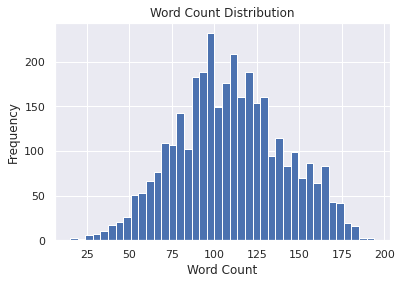

In [54]:
#exploatory statistics

research_df['summary_word_count'] = research_df['cleaned_summary'].astype('str').str.count(' ')

print(research_df.summary_word_count.describe())

# word count distribution
N = 100
print('{} documents in total'.format(research_df.shape[0]))
print('{} documents have fewer than {N} words'.format(research_df[research_df.summary_word_count<=N].shape[0], N = N))
print('{}% documents have fewer than {N} words'.format(round(research_df[research_df.summary_word_count<=N].shape[0]/research_df.shape[0]*100, 1), N = N))

ax = research_df.summary_word_count.plot.hist(bins=40)
ax.set_title("Word Count Distribution")
ax.set_xlabel('Word Count')

Based on this, it seems that out of the 1548 sample of articles we queried from arXiv, 685 of them have fewer than 100 words. This corresponds to 44.3% of the data having fewer than 100 words.



## Unsupervised Learning

We will be using LDA as the topic modelling algorithm in Python for the unsupervised learning approach associated with identifying the topics of research papers. LDA is a common approach to topic modelling and is the same approach large organizations like AWS provide as a service when using their Comprehend tool. This approach will essentially outline the backend code AWS would be using to process documents and generate topics for each of them in an unsupervised approach. At least this way, you won’t have to pay for it (aside from computing costs — which depends on the quantity of data you’re working with).

In [55]:
import nltk
nltk.download('punkt')
article_summaries = research_df['cleaned_summary'].values
article_summaries = [[word for word in nltk.word_tokenize(article)] for article in article_summaries]

# create a dictionary of all the words in the dataset
dictionary = corpora.Dictionary(article_summaries)

# create a corpus
corpus = [dictionary.doc2bow(article) for article in article_summaries]

# create an LDA model
lda = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=20)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [56]:
lda_vis = pyLDAvis.gensim.prepare(
    lda,
    corpus, 
    dictionary=lda.id2word,
    mds='mmds',
    sort_topics=False
)

pyLDAvis.display(lda_vis)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


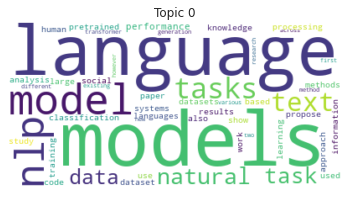

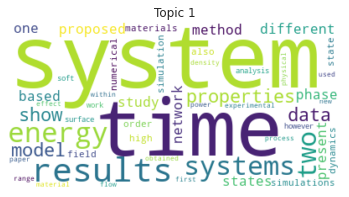

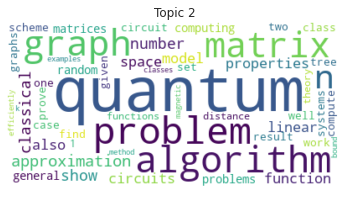

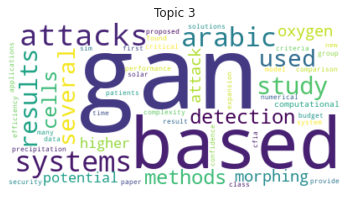

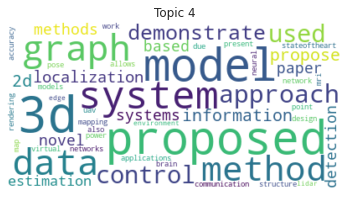

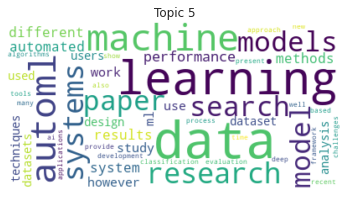

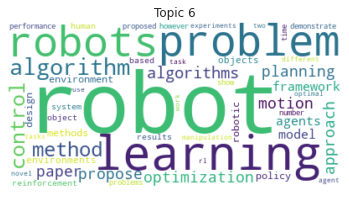

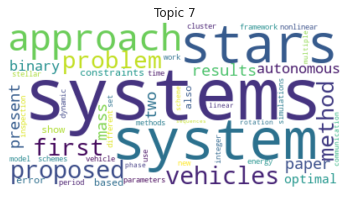

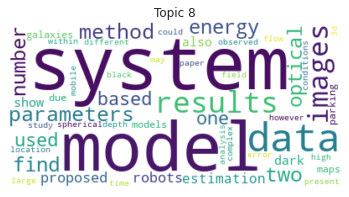

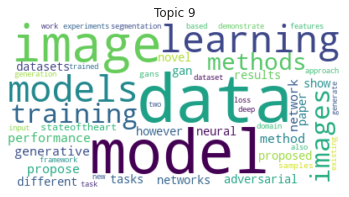

In [57]:
def create_wordcloud(model: models.LdaModel, topic: int):
    '''
    This class will generate a word cloud given an LDA Model and the topic.
    
    Args:
        mdl: LDA Model
        topic: Integer representing the topic
    '''
    text = {word: value for word, value in model.show_topic(topic, topn=50)}
    wc = WordCloud(
        background_color="white",
        max_words=1000
    )
    wc.generate_from_frequencies(text)
    plt.clf()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic" + " "+ str(topic))
    plt.show()
    
for i in range (0,10):
    create_wordcloud(lda, topic=i)

As you can see that there is quite a bit of overlap between the topics (namely with terms like model and models). Based on this it can be seen that further preprocessing and cleaning would be required to take the stem of a word, remove further stop words like use, show, first, also, may, one, number, etc... . The model development process is an iterative one but this highly outlines the importance of having high quality data being fed into the model

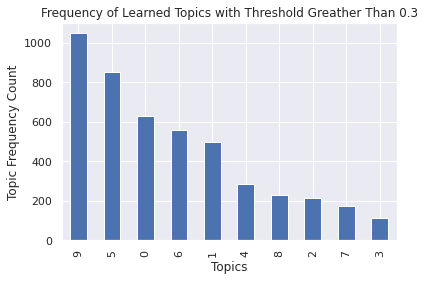

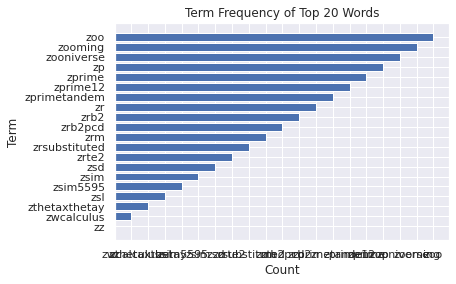

In [58]:
#topic analysis

def top_relevant_topics_per_article(mdl: models.LdaModel, corpus: list, articles: list, th: int) -> pd.DataFrame:
    """This method will create a dataframe which identifies the top relevant topics
    greater than a threshold for a given article.
    
    Args:
        mdl: LDA model
        corpus: List of tuples holding the corpus
        articles: List of strings with the article summaries
        th: Integer indicating the threshold of probability the topic must be greater than
    
    Returns:
        A DataFrame with the columns "articl", "topic" and "probability".
    """
    relevant_df = []
    
    for i, article in enumerate(articles):
        topics = mdl.get_document_topics(corpus[i])
        topics = sorted(topics, key = lambda x : x[1], reverse = True)[:5]
        for topic in topics:
            proba = topic[1]
            if proba > th:
                data = {
                    "article" : article,
                    "topic" : topic[0],
                    "proba" : proba
                }
                relevant_df.append(pd.DataFrame([data]))
    return pd.concat(relevant_df)
    
th = 0.3
articles = [' '.join(article) for article in article_summaries]
rel_df = top_relevant_topics_per_article(lda, corpus, articles, th)

plt.clf()
rel_df['topic'].value_counts().plot(kind = 'bar')
plt.xlabel("Topics")
plt.ylabel("Topic Frequency Count")
plt.title("Frequency of Learned Topics with Threshold Greather Than {th}".format(th=th))
plt.show()

list_sorted_token = sorted(lda.id2word.items(), key=lambda item: item[1], reverse=True)

term_freq_df = pd.DataFrame(
    data={
        'term' : [lda.id2word[key] for (key, value) in list_sorted_token],
        'term_freq': [value for (key, value) in list_sorted_token]
    }
)

N = 20
plt.clf()
plt.barh(
    term_freq_df.head(N)['term'],
    term_freq_df.head(N)['term_freq']
)
plt.xlabel("Count")
plt.ylabel("Term")
plt.title("Term Frequency of Top {N} Words".format(N = N))
plt.show()

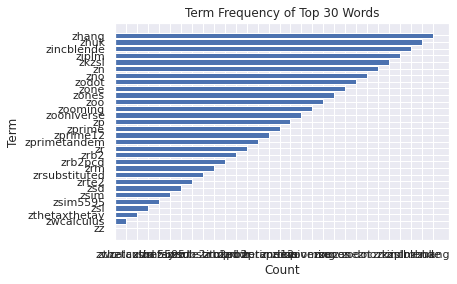

In [59]:
list_sorted_token = sorted(lda.id2word.items(), key=lambda item: item[1], reverse=True)

term_freq_df = pd.DataFrame(
    data={
        'term' : [lda.id2word[key] for (key, value) in list_sorted_token],
        'term_freq': [value for (key, value) in list_sorted_token]
    }
)

N = 30
plt.clf()
plt.barh(
    term_freq_df.head(N)['term'],
    term_freq_df.head(N)['term_freq']
)
plt.xlabel("Count")
plt.ylabel("Term")
plt.title("Term Frequency of Top {N} Words".format(N = N))
plt.show()

## Supervised Learning
The supervised learning approach to topic modelling will consist of generating topic labels to train a binary classification model. This can be done by identifying the keywords associated to topics we are interested in labelling and predicting. I will mainly focus on the three topics of machine learning, nlp (natural language processing) and mathematics .

This is the set of keywords I’ve identified per topic. By no means is this list exhaustive but it is good enough to begin with.



In [60]:
topics_dct = {
    'machinelearning': [
        'machinelearning', 'clustering', 'classification', 'regression',
        'supervised machine learning', 'unsupervised machine learning'
    ],
    'mathematics': [
        'mathematics', 'graph theory', 'combinatorics', 'calculus',
        'linear algebra', 'probability', 'statistics', 'trigonometry', 
        'topology', 'differential equations', 'differentiate', 'algebra'
    ],
    'nlp': [
        'natural language', 'topic modelling', 'sentiment analysis', 
        'translation', 'chat bot', 'text analysis', 'text mining', 
        'semantic analysis', 'summarization', 'linguistic processing', 
        'language recognition', 'text processing', 'language models', 
        'linguistic', 'sequencetosequence', 'neural machine translation', 
        'word embeddings', 'word2vec'
    ]
}

{'classification': 1}                                          181
{'classification': 2}                                           64
{'probability': 1}                                              55
{'translation': 1}                                              36
{'statistics': 1}                                               31
                                                              ... 
{'translation': 1, 'classification': 6}                          1
{'translation': 1, 'classification': 1, 'summarization': 1}      1
{'classification': 2, 'translation': 1}                          1
{'linguistic': 2, 'classification': 1}                           1
{'clustering': 1, 'classification': 2}                           1
Name: kw_frequency, Length: 120, dtype: int64


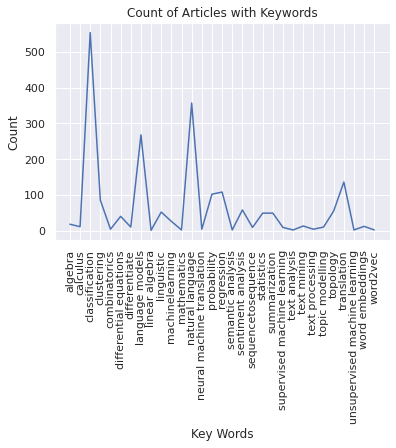

In [61]:
#EDA

topics_dct = {
    'machinelearning': [
        'machinelearning', 'clustering', 'classification', 'regression', 'supervised machine learning', 'unsupervised machine learning'
    ],
    'mathematics': [
        'mathematics', 'graph theory', 'combinatorics', 'calculus', 'linear algebra', 'probability', 'statistics', 'trigonometry', 'topology', 
        'differential equations', 'differentiate', 'algebra'
    ],
    'nlp': [
        'natural language', 'topic modelling', 'sentiment analysis', 'translation', 'chat bot', 'text analysis', 'text mining', 'semantic analysis',
        'summarization', 'linguistic processing', 'language recognition', 'text processing', 'language models', 'linguistic', 'sequencetosequence',
        'neural machine translation', 'word embeddings', 'word2vec'
    ]
}

kw_df = research_df[['article_id', 'url', 'all_topics', 'cleaned_summary']].copy()
all_kws = list(topics_dct.values())
all_kws = all_kws[0] + all_kws[1] + all_kws[2]
kw_df['kw_frequency'] = kw_df['cleaned_summary'].apply(lambda x: {k: v for k, v in Counter(x.split()).items() if k in all_kws} or 0)

print(kw_df[kw_df['kw_frequency'] != 0]['kw_frequency'].astype('str').value_counts())

def kw_frequency(df: pd.DataFrame, col: str, all_kws: list) -> pd.DataFrame:
    '''
    This method will take the input dataframe, scan through the text in the column and count 
    the occurrences of the keywords. It will create new columns on the input dataframe where
    each column corresponds to a keyword from all_kws.
    
    Args:
        df: DataFrame holding the text column you want to scan over
        col: String corresponding to a column name in the input df
        all_kws: List of unique keywords you want to count in the column
    
    Returns:
        A DataFrame with additional columns corresponding to the keywords in all_kws.
    '''
    freq_df = (
        df[col].str.extractall(r'\b({})\b'.format('|'.join(all_kws)))
               .groupby(level=0)[0]
               .value_counts()
               .unstack()
               .reindex(df.index)
               .rename_axis(None, axis=1)
    ).fillna(0)
    return freq_df

freq_ = kw_frequency(df = research_df, col = 'cleaned_summary', all_kws = all_kws).sum(axis = 0)
plt.clf()
plt.plot(freq_.index, freq_.values)
plt.title("Count of Articles with Keywords")
plt.xticks(rotation = 90)
plt.xlabel("Key Words")
plt.ylabel("Count")
plt.show()


In [62]:
#generate label

def generate_labels(topics_dct: dict, df: pd.DataFrame, col: str) -> pd.DataFrame:
    '''
    This method will generate binary labels associated with each topic in topics_dct
    by counting the keyword occurrences associated with that topic.
    
    Args:
        df: DataFrame holding the text column you want to scan over
        col: String corresponding to a column name in the input df
        topics_dct: Dictionary of unique topics and list of keywords you want to count
                    in the column
    
    Returns:
        The input dataframe with additional columns corresponding to the label for each
        topic in topics_dct
    '''    
    for topic,kw in topics_dct.items():
        # count the occurrences of. the keywords in the summary
        df[topic + '_label'] = df[col].apply(lambda x : [1 for word, count in Counter(x.split()).items() if word in kw] or np.nan)

        # generate binary classification -- 1 if the keyword was in the article, 0 otherwise
        df[topic + '_label'] = df[topic + '_label'].apply(lambda x : [1 if isinstance(x, list) else np.nan][0])
        df[topic + '_label'] = df[topic + '_label'].fillna(0)
    return df
kw_df = generate_labels(topics_dct, kw_df, 'cleaned_summary')

print(kw_df.head())
for col in ['machinelearning_label', 'mathematics_label', 'nlp_label']:
    print(col, kw_df[col].sum())

   article_id                                url  \
0           0  http://arxiv.org/pdf/2302.03255v1   
1           1  http://arxiv.org/pdf/2301.11316v1   
2           2  http://arxiv.org/pdf/2301.09524v2   
3           3  http://arxiv.org/pdf/2301.05102v1   
4           4  http://arxiv.org/pdf/2212.14668v1   

                            all_topics  \
0                              [cs.LG]   
1  [cs.LG, cs.AI, cs.CV, cs.HC, cs.IR]   
2                       [cs.NE, cs.AI]   
3                [cs.LG, cs.NE, cs.PF]   
4           [astro-ph.IM, astro-ph.CO]   

                                     cleaned_summary  \
0  combined algorithm selection hyperparameters o...   
1  work formulates machine learning mechanism bil...   
2  perinstance automated algorithm configuration ...   
3  resourceintensive computations major factor li...   
4  redshift measurement always constant need mode...   

                          kw_frequency  machinelearning_label  \
0                               

In [63]:
text_col = 'cleaned_summary'
topic_models = {}

for topic in topics_dct.keys():
    print(topic)
    label_col = topic + '_label'
    positive_label_count = kw_df[label_col].sum()
    negative_label_count = kw_df.shape[0] - positive_label_count
    
    positive_labels = kw_df[kw_df[label_col] == 1].sample(round(positive_label_count * 0.8)).copy()
    negative_labels = kw_df[kw_df[label_col] == 0].sample(round(negative_label_count * 0.8)).copy()
    training_df = pd.concat([positive_labels, negative_labels])
    holdout_df = kw_df[~kw_df['url'].isin(training_df['url'])]
    print("Training Data Shape: ", training_df.shape)
    print("Holdout Data Shape: ", holdout_df.shape)
    print(training_df[label_col].value_counts())
    print(holdout_df[label_col].value_counts())
    
    # create the sklearn pipeline
    pipe = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('classifier', GradientBoostingClassifier())
    ])
    pipe.fit(training_df[text_col], training_df[label_col])
    scores = cross_val_score(pipe, training_df[text_col], training_df[label_col], cv=4)
    print("Mean CV Score: ", scores.mean())
    topic_models[topic] = {
        'model' : pipe,
        'training_data' : training_df,
        'holdout_data' : holdout_df
    }

topic_models['machinelearning']['model']


machinelearning
Training Data Shape:  (2737, 8)
Holdout Data Shape:  (508, 8)
0.0    2383
1.0     354
Name: machinelearning_label, dtype: int64
0.0    436
1.0     72
Name: machinelearning_label, dtype: int64
Mean CV Score:  1.0
mathematics
Training Data Shape:  (2737, 8)
Holdout Data Shape:  (536, 8)
0.0    2595
1.0     142
Name: mathematics_label, dtype: int64
0.0    510
1.0     26
Name: mathematics_label, dtype: int64
Mean CV Score:  0.9992695394203269
nlp
Training Data Shape:  (2737, 8)
Holdout Data Shape:  (529, 8)
0.0    2630
1.0     107
Name: nlp_label, dtype: int64
0.0    508
1.0     21
Name: nlp_label, dtype: int64
Mean CV Score:  0.9985396124130277


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('classifier', GradientBoostingClassifier())])

In [64]:
for topic, mdl_dct in topic_models.items():
    print(topic)
    mdl = mdl_dct['model']
    holdout_df = mdl_dct['holdout_data']
    train_df = mdl_dct['training_data']
    holdout_df['prediction'] = mdl.predict(holdout_df[text_col])
    correct_predictions = holdout_df[holdout_df['prediction'] == holdout_df[topic + '_label']]
    print("Accuracy on Holdout Data : ", correct_predictions.shape[0] / holdout_df.shape[0])
    # cv_scores = cross_val_score(mdl, train_df[text_col], train

machinelearning


<ipython-input-64-293d40bf6155>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holdout_df['prediction'] = mdl.predict(holdout_df[text_col])


Accuracy on Holdout Data :  1.0
mathematics
Accuracy on Holdout Data :  0.9981343283582089
nlp
Accuracy on Holdout Data :  1.0
